In [1]:
import numpy as np
from numpy.random import default_rng
import torch
import torch.nn.functional as F
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from matplotlib.patches import Rectangle
from scipy.stats import sem, pearsonr, mannwhitneyu
from my_utils import *
from sklearn.linear_model import RidgeCV

from pathlib import Path
import sys
import warnings

In [2]:
modelpath = Path('../model')
sys.path.append(str(modelpath))
import config.config as config

In [3]:
# agents checkpoints path
progress_agents_path = Path('../data/agents_all')
# agents checkpoints performance path
training_curve_path = Path('../data/training_curve')
# figure path
figure_path = Path('../paper_figures/figure8')

# Gain task

In [4]:
arg = config.ConfigGain()
arg.device = 'cpu'
arg.process_gain_range = [3, 4.0001]

## Choose agents

In [5]:
Actors = [f'Actor{i}' for i in range(1, 4)]
Critics = [f'Critic{i}' for i in range(1, 6)]
for model in Actors + Critics:
    exec(f'from {model} import {model[:-1]} as {model}')
agent_archs = [''.join(i) for i in cartesian_prod(Actors, Critics)]

MAX_TRAINING_T = 1e5

In [6]:
def select_agents_all(progress_agents_path, agent_archs, MAX_TRAINING_T, task='gain', onlytrained=False):  
    perform_files = [[pd.read_csv(file)[(pd.read_csv(file).episode > 0) & (pd.read_csv(file).episode < MAX_TRAINING_T)] 
                      for file in (training_curve_path / task).glob(f'{agent_arch}*.*')] 
                     for agent_arch in agent_archs]
    seeds = [[''.join(filter(str.isdigit, file.stem.split('_')[1]))
              for file in (training_curve_path / task).glob(f'{agent_arch}*.*')] 
             for agent_arch in agent_archs]
    
    agent_paths = []; agent_files = []
    for agent_arch, seeds_ in zip(agent_archs, seeds): # loop each agent
        agent_path = []; agent_file = []
        for seed in seeds_:
            perform_file_path = training_curve_path / task / f'{agent_arch}_seed{seed}.csv'
            perform_file = pd.read_csv(perform_file_path)
            perform_file = perform_file[(perform_file.episode > 0) & (perform_file.episode < MAX_TRAINING_T)]
            if not onlytrained:
                best_episode = perform_file.episode.unique()[np.sum([perform_file[perform_file.task == task].reward_rate 
                                        for task in perform_file.task.unique()], axis=0).argmax()]
            else:
                best_episode = perform_file.episode.unique()[np.sum([perform_file[perform_file.task == task].reward_rate 
                                        for task in perform_file.task.unique()
                                                                if task in ['gain1x', 'perturbation0']], axis=0).argmax()]
            
            agent_path.append(progress_agents_path / agent_arch / 'gain' / f'seed{seed}')
            agent_file.append(list(agent_path[-1].glob(f'*-{best_episode}.*'))[0].stem.split('.')[0])
        agent_paths.append(agent_path); agent_files.append(agent_file)
    
    
    return agent_paths, agent_files, perform_files

In [7]:
agent_paths, agent_files, perform_files = select_agents_all(progress_agents_path, agent_archs, 
                                                            MAX_TRAINING_T, task='gain_full')

In [8]:
agent_paths_1x, agent_files_1x, _ = select_agents_all(progress_agents_path, agent_archs, 
                                                      MAX_TRAINING_T, task='gain_full', onlytrained=True)

In [9]:
mean_reward_rate = [np.vstack([np.mean([file[file.task == task].reward_rate 
                                        for task in file.task.unique() if task == 'gain1x'], axis=0)
                               for file in perform_file]).mean(axis=0) 
                    for perform_file in perform_files]
sem_reward_rate = [sem(np.vstack([np.mean([file[file.task == task].reward_rate 
                                           for task in file.task.unique() if task == 'gain1x'], 
                                          axis=0) 
                                  for file in perform_file]), axis=0) 
                   for perform_file in perform_files]
mean_reward_1x = [np.vstack([file[file.task == 'perturbation0'].reward_fraction for file in perform_file]).mean(axis=0) 
                  for perform_file in perform_files]

## Run agents in the gain task

In [10]:
from Agent_RNN import *
from Environment import Env

In [11]:
def RNN_agent_simulation(agent, target_positions, gains, arg):
    reset_seeds(0)
    env = Env(arg)
    agent.bstep.obs_noise_range = arg.obs_noise_range

    pos_x = []; pos_x_end = []; pos_y = []; pos_y_end = []
    head_dir = []; head_dir_end = []; pos_r = []; pos_theta = []; pos_r_end = []; pos_theta_end = []; 
    pos_v = []; pos_w = []
    target_x = []; target_y = []; target_r = []; target_theta = []
    rewarded = []; relative_radius = []; relative_angle = []
    action_v = []; action_w = []
    relative_radius_end = []; relative_angle_end = []
    steps = []; state_ = []; action_ = []
    td_error = []

    for target_position, gain in zip(target_positions, gains):
        cross_start_threshold = False
        reward = torch.zeros(1, 1, 1)
        x = env.reset(target_position=target_position, pro_gains=gain)
        agent.bstep.reset(env.pro_gains)
        last_action = torch.zeros([1, 1, arg.ACTION_DIM])
        last_action_raw = last_action.clone()

        state = torch.cat([x[-arg.OBS_DIM:].view(1, 1, -1), last_action,
                           env.target_position_obs.view(1, 1, -1)], dim=2).to(arg.device)

        hidden_in = None

        true_states = []
        actions = []
        states = []
        rewards = []
        
        for t in range(arg.EPISODE_LEN):
            if not cross_start_threshold and (last_action_raw.abs() > arg.TERMINAL_ACTION).any():
                cross_start_threshold = True
                
            action, action_raw, hidden_out = agent.select_action(state, hidden_in, action_noise=None)
            next_x, reached_target, _ = env(x, action, t)
            next_ox = agent.bstep(next_x)
            next_state = torch.cat([next_ox.view(1, 1, -1), action,
                                    env.target_position_obs.view(1, 1, -1)], dim=2).to(arg.device)

            is_stop = env.is_stop(x, action)
            
            if is_stop and cross_start_threshold:
                reward = env.return_reward(x, reward_mode='mixed')

            true_states.append(x)
            states.append(state)
            actions.append(action)
            rewards.append(reward)

            if is_stop and cross_start_threshold:
                break
                
            last_action_raw = action_raw
            state = next_state
            x = next_x
            hidden_in = hidden_out

        # Trial end
        # TD errors
        states = torch.cat(states)
        actions = torch.cat(actions)
        rewards = torch.cat(rewards)
        dones = torch.zeros_like(rewards); dones[-1] = 1
        with torch.no_grad():
            Q = agent.critic.Q1(states, actions)
            next_Q = torch.zeros_like(Q); next_Q[:-1] = Q[1:]
            td_error_ = rewards + (1-dones) * arg.GAMMA * next_Q - Q
        
        td_error.append(abs(td_error_).mean().item())
        
        # other stuff
        pos_x_temp, pos_y_temp, head_dir_temp, pos_v_temp, pos_w_temp \
                    = torch.chunk(torch.cat(true_states, dim=1), x.shape[0], dim=0)
        pos_x.append(pos_x_temp.view(-1).numpy() * arg.LINEAR_SCALE)
        pos_y.append(pos_y_temp.view(-1).numpy() * arg.LINEAR_SCALE)
        pos_x_end.append(pos_x[-1][-1])
        pos_y_end.append(pos_y[-1][-1])
        head_dir.append(np.rad2deg(head_dir_temp.view(-1).numpy()))
        pos_v.append(pos_v_temp.view(-1).numpy() * arg.LINEAR_SCALE)
        pos_w.append(np.rad2deg(pos_w_temp.view(-1).numpy()))
        head_dir_end.append(head_dir[-1][-1])

        rho, phi = cart2pol(pos_x[-1], pos_y[-1])
        pos_r.append(rho)
        pos_theta.append(np.rad2deg(phi))
        pos_r_end.append(rho[-1])
        pos_theta_end.append(np.rad2deg(phi[-1]))

        target_x.append(target_position[0].item() * arg.LINEAR_SCALE)
        target_y.append(target_position[1].item() * arg.LINEAR_SCALE)
        tar_rho, tar_phi = cart2pol(target_x[-1], target_y[-1])
        target_r.append(tar_rho)
        target_theta.append(np.rad2deg(tar_phi))
        
        state_.append(states)

        action_.append(actions)
        action_v_temp, action_w_temp = torch.chunk(actions.squeeze(1), 
                                                   action.shape[-1], dim=1)
        action_v.append(action_v_temp.view(-1).numpy())
        action_w.append(action_w_temp.view(-1).numpy())
        
        relative_r, relative_ang = get_relative_r_ang(pos_x[-1], pos_y[-1], head_dir[-1], 
                                                      target_x[-1], target_y[-1])
        relative_radius.append(relative_r)
        relative_angle.append(np.rad2deg(relative_ang))
        relative_radius_end.append(relative_r[-1])
        relative_angle_end.append(np.rad2deg(relative_ang[-1]))
        rewarded.append((reached_target & is_stop).item())
        
        steps.append(np.arange(relative_r.size))

    agent.bstep.obs_noise_range = config.ConfigGain().obs_noise_range
    
    return(pd.DataFrame().assign(pos_x=pos_x, pos_y=pos_y, pos_x_end=pos_x_end, pos_y_end=pos_y_end,
                                 head_dir=head_dir, head_dir_end=head_dir_end, 
                                 pos_r=pos_r, pos_theta=pos_theta, 
                                 pos_r_end=pos_r_end, pos_theta_end=pos_theta_end, pos_v=pos_v, 
                                 pos_w=pos_w, target_x=target_x, target_y=target_y, 
                                 target_r=target_r,
                                 target_theta=target_theta, rewarded=rewarded,
                                 relative_radius=relative_radius, relative_angle=relative_angle,
                                 action_v=action_v, action_w=action_w, 
                                 relative_radius_end=relative_radius_end,
                                 relative_angle_end=relative_angle_end,
                                 steps=steps, gain_v=torch.stack(gains)[:, 0].numpy(),
                                 gain_w=torch.stack(gains)[:, 1].numpy(), 
                                 state=state_, action=action_, td_error=td_error))

In [12]:
SAMPLE_SIZE = 2000

reset_seeds(0)
env = Env(arg)
target_positions = []
gains = []

for _ in range(SAMPLE_SIZE):
    __ = env.reset()
    target_positions.append(env.target_position)
    gains.append(env.pro_gains)

In [13]:
agents_all = []
for idx, agent_arch in enumerate(agent_archs):
    agents_ = []
    for agent_path, agent_file in zip(agent_paths[idx], agent_files[idx]):
        agent = Agent(arg, eval(agent_arch[:6]), eval(agent_arch[6:]))
        agent.data_path = agent_path
        agent.load(agent_file, load_memory=False, load_optimzer=False)
        agents_.append(agent)
    agents_all.append(agents_)

In [14]:
agent_trajectories_all = [[RNN_agent_simulation(agent, target_positions, gains, arg) for agent in agents_] 
                          for agents_ in agents_all]

In [15]:
gains_1x = [arg.process_gain_default for _ in range(len(gains))]

agents_all_1x = []
for idx, agent_arch in enumerate(agent_archs):
    agents_ = []
    for agent_path, agent_file in zip(agent_paths_1x[idx], agent_files_1x[idx]):
        agent = Agent(arg, eval(agent_arch[:6]), eval(agent_arch[6:]))
        agent.data_path = agent_path
        agent.load(agent_file, load_memory=False, load_optimzer=False)
        agents_.append(agent)
    agents_all_1x.append(agents_)

In [16]:
agent_trajectories_1x = [[RNN_agent_simulation(agent, target_positions, gains_1x, arg) for agent in agents_] 
                         for agents_ in agents_all_1x]

## Figures

In [17]:
locals().update(config_colors())
major_formatter = FuncFormatter(my_tickformatter)

fontsize = 7
lw = 1

## S9a

In [18]:
argments = {'OBS_DIM': arg.OBS_DIM, 'ACTION_DIM': arg.ACTION_DIM, 'TARGET_DIM': arg.TARGET_DIM,
            'RNN_SIZE': arg.RNN_SIZE, 'FC_SIZE': arg.FC_SIZE, 'RNN': arg.RNN}

In [19]:
num_param_actor = pd.DataFrame([[sum([param.numel() for param in eval(actor)(**argments).parameters()]) 
                                 for actor in Actors]], columns=[' '.join([i[:-1], i[-1]]) for i in Actors])
num_param_critic = pd.DataFrame([[int(sum([param.numel() for param in eval(critic)(**argments).parameters()]) / 2)
                                  for critic in Critics]], columns=[' '.join([i[:-1], i[-1]]) for i in Critics])
color_critic = ['#db7093', '#a57791', '#6f7e8f', '#34858d', '#008b8b']

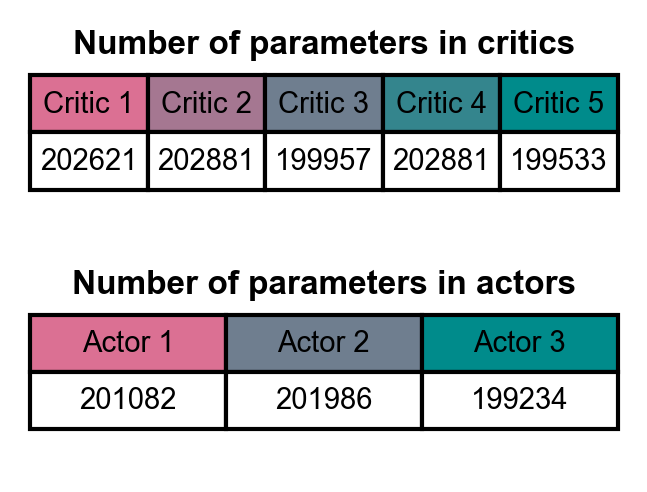

In [20]:
width = 2
height = 1.5

titles = ['critics', 'actors']
num_params = [num_param_critic, num_param_actor]

with initiate_plot(width, height, 300) as fig:
    for f_idx in range(2):
        ax = fig.add_subplot(2, 1, f_idx + 1)
        ax.set_title(f'Number of parameters in {titles[f_idx]}', fontsize=fontsize + 1, fontweight='bold', y=0.8)
        ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(False); ax.spines['left'].set_visible(False)
        plt.xticks([], fontsize=fontsize)
        plt.yticks([], fontsize=fontsize)

        c = color_critic if f_idx == 0 else color_critic[::2]
        t1 = ax.table(cellText=num_params[f_idx].values, cellLoc='center', rowLoc='center',
                      colLabels=num_params[f_idx].columns, colLoc='center',
                      colColours=c, loc='center')
        t1.auto_set_font_size(False)
        t1.set_fontsize(fontsize)
        
    fig.tight_layout(pad=0.15, rect=(0, 0, 1, 1), h_pad=1)
    
    #plt.savefig(figure_path / 'raw/{name}.pdf'.format(
    #    name='sup_num_params'), orientation='portrait', format='pdf', transparent=True)

## S9b

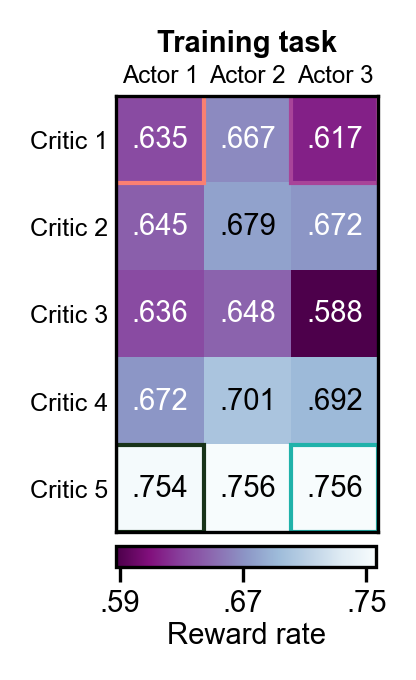

In [41]:
xticks = np.arange(len(Actors)); xticklabels = [f'Actor {i}' for i in range(1, 1 + len(Actors))]
yticks = np.arange(len(Critics)); yticklabels = [f'Critic {i}' for i in range(1, 1 + len(Critics))]
width = 1.5
height = 2.1

with initiate_plot(width, height, 300) as fig:
    ax = fig.add_subplot(111)
    ax.set_title('Training task', fontsize=fontsize, fontweight='bold', pad=3)
    plt.xticks(xticks, xticklabels, fontsize=fontsize - 1.2)
    plt.yticks(yticks, yticklabels, fontsize=fontsize - 1)
    ax.set_xlabel('', fontsize=fontsize)
    ax.set_ylabel('', fontsize=fontsize)
        
    data = np.array([np.mean([df.rewarded.sum() / 
                              (np.sum([d.pos_x.size - 1 for d in df.itertuples()]) * arg.DT) for df in dfs]) 
                     for dfs in agent_trajectories_1x]).reshape(len(Critics), len(Actors))
    cmatplot = ax.matshow(data, cmap='BuPu_r')  
    ax.tick_params(axis='both', which='major', pad=2, bottom=False, length=0)
    
    cbaxes = ax.inset_axes([0, -0.08, 0.99, 0.05]) 
    cbar = fig.colorbar(cmatplot, cax=cbaxes, orientation='horizontal')
    cbar.ax.tick_params(labelsize=fontsize, pad=2)
    cbar_ticks = [0.59, 0.67, 0.75]
    cbar.set_ticks(cbar_ticks)
    cbar.set_label('Reward rate', fontsize=fontsize)
    cbar.ax.xaxis.set_label_coords(0.5, -2.5)
    cbar.ax.xaxis.set_major_formatter(major_formatter)
    
    for iy, y in enumerate(np.arange(len(yticks))):
        for ix, x in enumerate(np.arange(len(xticks))):
            s = round(data[iy][ix], 3)
            c = 'k' if s > data.mean() else 'w'
            ax.text(x, y, s='.' + str(s).split('.')[1], fontsize=fontsize, 
                    c=c, va='center', ha='center')
            
    rect = Rectangle(xy=(-0.5, -0.5), width=1, height=1, fill=False, ec=holistic_c, lw=lw)
    ax.add_patch(rect)
    rect = Rectangle(xy=(1.5, -0.5), width=1, height=1, fill=False, ec=moact_hocri_c, lw=lw)
    ax.add_patch(rect)
    rect = Rectangle(xy=(-0.5, 3.5), width=1, height=1, fill=False, ec=hoact_mocri_c, lw=lw)
    ax.add_patch(rect)
    rect = Rectangle(xy=(1.5, 3.5), width=1, height=1, fill=False, ec=modular_c, lw=lw)
    ax.add_patch(rect)
    
    fig.tight_layout(pad=0, rect=(-0.01, 0, 0.99, 1))
    
    #plt.savefig(figure_path / 'raw/{name}.pdf'.format(
    #             name='reward_rate_normal'), orientation='portrait', format='pdf', transparent=True)

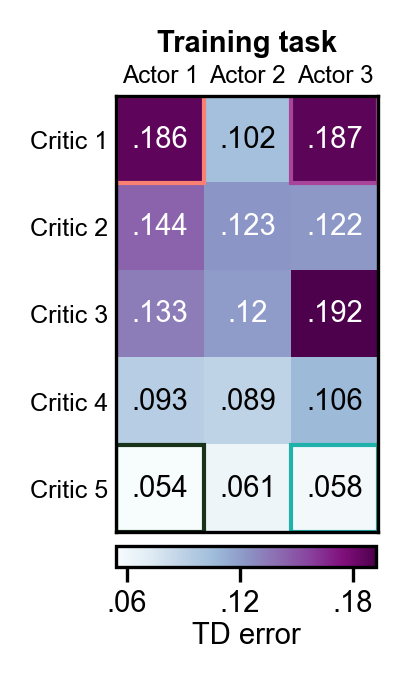

In [22]:
xticks = np.arange(len(Actors)); xticklabels = [f'Actor {i}' for i in range(1, 1 + len(Actors))]
yticks = np.arange(len(Critics)); yticklabels = [f'Critic {i}' for i in range(1, 1 + len(Critics))]
width = 1.5
height = 2.1

with initiate_plot(width, height, 300) as fig:
    ax = fig.add_subplot(111)
    ax.set_title('Training task', fontsize=fontsize, fontweight='bold', pad=3)
    plt.xticks(xticks, xticklabels, fontsize=fontsize - 1.2)
    plt.yticks(yticks, yticklabels, fontsize=fontsize - 1)
    ax.set_xlabel('', fontsize=fontsize)
    ax.set_ylabel('', fontsize=fontsize)
        
    data = np.array([np.mean([df.td_error.mean() for df in dfs]) 
                     for dfs in agent_trajectories_1x]).reshape(len(Critics), len(Actors))
    cmatplot = ax.matshow(data, cmap='BuPu')  
    ax.tick_params(axis='both', which='major', pad=2, bottom=False, length=0)
    
    cbaxes = ax.inset_axes([0, -0.08, 0.99, 0.05]) 
    cbar = fig.colorbar(cmatplot, cax=cbaxes, orientation='horizontal')
    cbar.ax.tick_params(labelsize=fontsize, pad=2)
    cbar_ticks = [0.06, 0.12, 0.18]
    cbar.set_ticks(cbar_ticks)
    cbar.set_label('TD error', fontsize=fontsize)
    cbar.ax.xaxis.set_label_coords(0.5, -2.5)
    cbar.ax.xaxis.set_major_formatter(major_formatter)
    
    for iy, y in enumerate(np.arange(len(yticks))):
        for ix, x in enumerate(np.arange(len(xticks))):
            s = round(data[iy][ix], 3)
            c = 'k' if s < data.mean() else 'w'
            ax.text(x, y, s='.' + str(s).split('.')[1], fontsize=fontsize, 
                    c=c, va='center', ha='center')
            
    rect = Rectangle(xy=(-0.5, -0.5), width=1, height=1, fill=False, ec=holistic_c, lw=lw)
    ax.add_patch(rect)
    rect = Rectangle(xy=(1.5, -0.5), width=1, height=1, fill=False, ec=moact_hocri_c, lw=lw)
    ax.add_patch(rect)
    rect = Rectangle(xy=(-0.5, 3.5), width=1, height=1, fill=False, ec=hoact_mocri_c, lw=lw)
    ax.add_patch(rect)
    rect = Rectangle(xy=(1.5, 3.5), width=1, height=1, fill=False, ec=modular_c, lw=lw)
    ax.add_patch(rect)
    
    fig.tight_layout(pad=0, rect=(-0.01, 0, 0.99, 1))
    
    #plt.savefig(figure_path / 'raw/{name}.pdf'.format(
    #             name='TD_error_normal'), orientation='portrait', format='pdf', transparent=True)

In [23]:
reward_rate = np.array([np.mean([df.rewarded.sum() / 
                                 (np.sum([d.pos_x.size - 1 for d in df.itertuples()]) * arg.DT) 
                                 for df in dfs]) 
                        for dfs in agent_trajectories_1x]).reshape(len(Critics), len(Actors))
TD_error = np.array([np.mean([df.td_error.mean() for df in dfs]) 
                     for dfs in agent_trajectories_1x]).reshape(len(Critics), len(Actors))

In [24]:
pearsonr(reward_rate.flatten(), TD_error.flatten())

PearsonRResult(statistic=-0.9292909679896406, pvalue=5.503905029825823e-07)

## S9c

In [25]:
max_reward_boundary = int(max([df.relative_radius_end.max() for dfs in agent_trajectories_all for df in dfs])) + 1
hypo_reward_boundaries = np.arange(max_reward_boundary)

targets = agent_trajectories_all[0][0][['target_x', 'target_y']].values
shuffled_targets = targets.copy()
rng = default_rng(1); rng.shuffle(shuffled_targets, axis=0)

ydata_subjects = []; xdata_subjects = []
for dfs in agent_trajectories_all:
    ydata_seeds = []; xdata_seeds = []
    for df in dfs:
        ydata = []; xdata = []
        for reward_boundary in hypo_reward_boundaries:
            ydata.append((np.linalg.norm(df[['pos_x_end', 'pos_y_end']].values - targets, axis=1) 
                          < reward_boundary).sum() / len(df))
            xdata.append((np.linalg.norm(df[['pos_x_end', 'pos_y_end']].values - shuffled_targets, axis=1) 
                          < reward_boundary).sum() / len(df))
        ydata_seeds.append(ydata); xdata_seeds.append(xdata)
    ydata_subjects.append(ydata_seeds); xdata_subjects.append(xdata_seeds)
    
    
auc_data = [[np.trapz(ydata_subjects[agent_idx][idx], xdata_subjects[agent_idx][idx]) 
             for idx in range(len(agent_trajectories_all[agent_idx]))] 
            for agent_idx in range(len(agent_trajectories_all))]
auc_mean = np.array([np.mean(i) for i in auc_data]).reshape(len(Critics), len(Actors))
auc_sem = np.array([sem(i) for i in auc_data]).reshape(len(Critics), len(Actors))

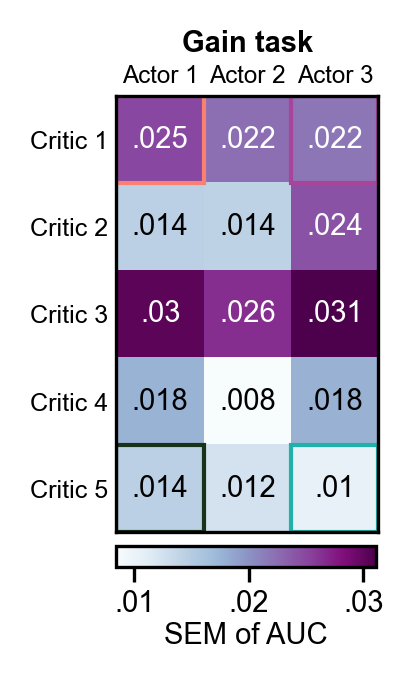

In [42]:
xticks = np.arange(len(Actors)); xticklabels = [f'Actor {i}' for i in range(1, 1 + len(Actors))]
yticks = np.arange(len(Critics)); yticklabels = [f'Critic {i}' for i in range(1, 1 + len(Critics))]
width = 1.5
height = 2.1

with initiate_plot(width, height, 300) as fig:
    ax = fig.add_subplot(111)
    ax.set_title('Gain task', fontsize=fontsize, fontweight='bold', pad=3)
    plt.xticks(xticks, xticklabels, fontsize=fontsize - 1.2)
    plt.yticks(yticks, yticklabels, fontsize=fontsize - 1)
    ax.set_xlabel('', fontsize=fontsize)
    ax.set_ylabel('', fontsize=fontsize)
        
    cmatplot = ax.matshow(auc_sem, cmap='BuPu')  
    ax.tick_params(axis='both', which='major', pad=2, bottom=False, length=0)
    
    cbaxes = ax.inset_axes([0, -0.08, 0.99, 0.05]) 
    cbar = fig.colorbar(cmatplot, cax=cbaxes, orientation='horizontal')
    cbar.ax.tick_params(labelsize=fontsize, pad=2)
    cbar_ticks = [0.01, 0.02, 0.03]
    cbar.set_ticks(cbar_ticks)
    cbar.set_label('SEM of AUC', fontsize=fontsize)
    cbar.ax.xaxis.set_label_coords(0.5, -2.5)
    cbar.ax.xaxis.set_major_formatter(major_formatter)
    
    for iy, y in enumerate(np.arange(len(yticks))):
        for ix, x in enumerate(np.arange(len(xticks))):
            s = round(auc_sem[iy][ix], 3)
            c = 'k' if s < auc_sem.mean() else 'w'
            ax.text(x, y, s='.' + str(s).split('.')[1], fontsize=fontsize, 
                    c=c, va='center', ha='center')
            
    rect = Rectangle(xy=(-0.5, -0.5), width=1, height=1, fill=False, ec=holistic_c, lw=lw)
    ax.add_patch(rect)
    rect = Rectangle(xy=(1.5, -0.5), width=1, height=1, fill=False, ec=moact_hocri_c, lw=lw)
    ax.add_patch(rect)
    rect = Rectangle(xy=(-0.5, 3.5), width=1, height=1, fill=False, ec=hoact_mocri_c, lw=lw)
    ax.add_patch(rect)
    rect = Rectangle(xy=(1.5, 3.5), width=1, height=1, fill=False, ec=modular_c, lw=lw)
    ax.add_patch(rect)
    
    fig.tight_layout(pad=0, rect=(-0.01, 0, 0.99, 1))
    
    #plt.savefig(figure_path / 'raw/{name}.pdf'.format(
    #             name='auc_sem_gain'), orientation='portrait', format='pdf', transparent=True)

## 8c

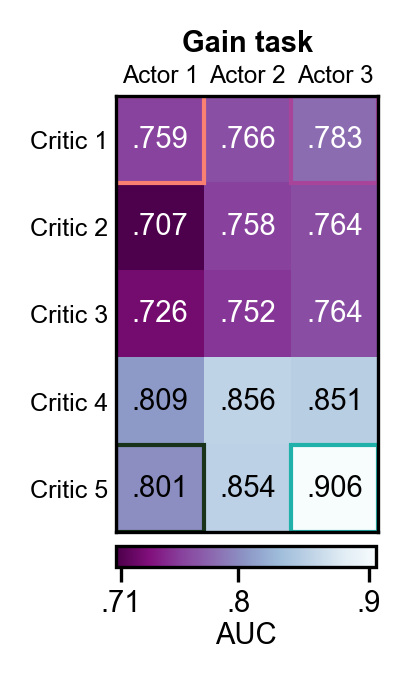

In [43]:
xticks = np.arange(len(Actors)); xticklabels = [f'Actor {i}' for i in range(1, 1 + len(Actors))]
yticks = np.arange(len(Critics)); yticklabels = [f'Critic {i}' for i in range(1, 1 + len(Critics))]
width = 1.5
height = 2.1

with initiate_plot(width, height, 300) as fig:
    ax = fig.add_subplot(111)
    ax.set_title('Gain task', fontsize=fontsize, fontweight='bold', pad=3)
    plt.xticks(xticks, xticklabels, fontsize=fontsize - 1.2)
    plt.yticks(yticks, yticklabels, fontsize=fontsize - 1)
    ax.set_xlabel('', fontsize=fontsize)
    ax.set_ylabel('', fontsize=fontsize)
        
    cmatplot = ax.matshow(auc_mean, cmap='BuPu_r')  
    ax.tick_params(axis='both', which='major', pad=2, bottom=False, length=0)
    
    cbaxes = ax.inset_axes([0, -0.08, 0.99, 0.05]) 
    cbar = fig.colorbar(cmatplot, cax=cbaxes, orientation='horizontal')
    cbar.ax.tick_params(labelsize=fontsize, pad=2)
    cbar_ticks = [0.71, 0.8, 0.9]
    cbar.set_ticks(cbar_ticks)
    cbar.set_label('AUC', fontsize=fontsize)
    cbar.ax.xaxis.set_label_coords(0.5, -2.5)
    cbar.ax.xaxis.set_major_formatter(major_formatter)
    
    for iy, y in enumerate(np.arange(len(yticks))):
        for ix, x in enumerate(np.arange(len(xticks))):
            s = round(auc_mean[iy][ix], 3)
            c = 'k' if s > auc_mean.mean() else 'w'
            ax.text(x, y, s='.' + str(s).split('.')[1], fontsize=fontsize, 
                    c=c, va='center', ha='center')
            
    rect = Rectangle(xy=(-0.5, -0.5), width=1, height=1, fill=False, ec=holistic_c, lw=lw)
    ax.add_patch(rect)
    rect = Rectangle(xy=(1.5, -0.5), width=1, height=1, fill=False, ec=moact_hocri_c, lw=lw)
    ax.add_patch(rect)
    rect = Rectangle(xy=(-0.5, 3.5), width=1, height=1, fill=False, ec=hoact_mocri_c, lw=lw)
    ax.add_patch(rect)
    rect = Rectangle(xy=(1.5, 3.5), width=1, height=1, fill=False, ec=modular_c, lw=lw)
    ax.add_patch(rect)
    
    fig.tight_layout(pad=0, rect=(-0.01, 0, 0.99, 1))
    
    #plt.savefig(figure_path / 'raw/{name}.pdf'.format(
    #             name='auc_gain'), orientation='portrait', format='pdf', transparent=True)

In [26]:
def get_neural_response(agent, df):
    responses = []
    with torch.no_grad():
        for _, trial in df.iterrows():
            if agent.actor.rnn.num_layers == 1:
                response = agent.actor.rnn(trial.state)[0]
            else:
                hidden = (torch.zeros(agent.actor.rnn.num_layers, 1, agent.actor.rnn.hidden_size),) * 2
                response = []
                for t in range(trial.state.shape[0]):
                    state = trial.state[t:t + 1]
                    _, hidden = agent.actor.rnn(state, hidden)
                    response.append(hidden[0][:1])
                response = torch.cat(response)
                
            responses.append(response.squeeze(1))
        df['response'] = responses
    return torch.cat(responses).numpy()

In [27]:
_ = [[get_neural_response(agent, df) for agent, df in zip(agents_, dfs)] 
     for agents_, dfs in zip(agents_all, agent_trajectories_all)]

In [28]:
train_frac = 0.7
def fit_decoder(trajectory, start_idx=0, variables=['pos_x', 'pos_y']):
    key = 'response'
    train_trajectory = trajectory[:round(len(trajectory) * train_frac)]
    train_X = np.vstack([x[start_idx:] for _, x in train_trajectory[key].iteritems()])
    test_trajectory = trajectory[round(len(trajectory) * train_frac):]
    test_X = np.vstack([x[start_idx:] for _, x in test_trajectory[key].iteritems()])
    
    y = train_trajectory[variables].values
    train_y = np.vstack([np.hstack([v[start_idx:] for v in y[:, i]]) for i in range(y.shape[1])]).T
    y = test_trajectory[variables].values
    test_y = np.vstack([np.hstack([v[start_idx:] for v in y[:, i]]) for i in range(y.shape[1])]).T
    
    decoder = RidgeCV()
    decoder.fit(train_X, train_y)
    
    return decoder, test_X, test_y

In [29]:
decoders = [list(map(fit_decoder, dfs)) for dfs in agent_trajectories_all]

In [30]:
decoding_errors = [[np.linalg.norm(deco[0].predict(deco[1]) - deco[2], axis=1).mean() for deco in decoder]
                   for decoder in decoders]
decoding_errors_mean = np.array([np.mean(v) for v in decoding_errors]).reshape(len(Critics), len(Actors))
decoding_errors_sem = np.array([sem(v) for v in decoding_errors]).reshape(len(Critics), len(Actors))

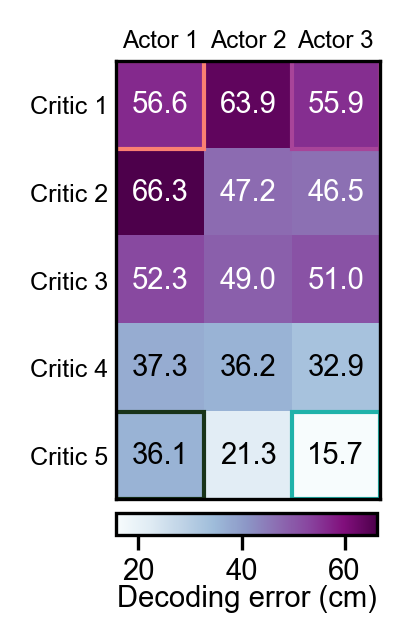

In [44]:
xticks = np.arange(len(Actors)); xticklabels = [f'Actor {i}' for i in range(1, 1 + len(Actors))]
yticks = np.arange(len(Critics)); yticklabels = [f'Critic {i}' for i in range(1, 1 + len(Critics))]
width = 1.5
height = 2.1

with initiate_plot(width, height, 300) as fig:
    ax = fig.add_subplot(111)
    plt.xticks(xticks, xticklabels, fontsize=fontsize - 1.2)
    plt.yticks(yticks, yticklabels, fontsize=fontsize - 1) 
    ax.set_xlabel('', fontsize=fontsize)
    ax.set_ylabel('', fontsize=fontsize)
        
    cmatplot = ax.matshow(decoding_errors_mean, cmap='BuPu')   
    ax.tick_params(axis='both', which='major', pad=2, bottom=False, length=0)
    
    cbaxes = ax.inset_axes([0, -0.08, 0.99, 0.05]) 
    cbar = fig.colorbar(cmatplot, cax=cbaxes, orientation='horizontal')
    cbar.ax.tick_params(labelsize=fontsize, pad=2)
    cbar_ticks = [20, 40, 60]
    cbar.set_ticks(cbar_ticks)
    cbar.set_label('Decoding error (cm)', fontsize=fontsize)
    cbar.ax.xaxis.set_label_coords(0.5, -2.3)
    
    for iy, y in enumerate(np.arange(len(yticks))):
        for ix, x in enumerate(np.arange(len(xticks))):
            s = round(decoding_errors_mean[iy][ix], 1)
            c = 'k' if s < decoding_errors_mean.mean() else 'w'
            ax.text(x, y, s=s, fontsize=fontsize, 
                    c=c, va='center', ha='center')
            
    rect = Rectangle(xy=(-0.5, -0.5), width=1, height=1, fill=False, ec=holistic_c, lw=lw)
    ax.add_patch(rect)
    rect = Rectangle(xy=(1.5, -0.5), width=1, height=1, fill=False, ec=moact_hocri_c, lw=lw)
    ax.add_patch(rect)
    rect = Rectangle(xy=(-0.5, 3.5), width=1, height=1, fill=False, ec=hoact_mocri_c, lw=lw)
    ax.add_patch(rect)
    rect = Rectangle(xy=(1.5, 3.5), width=1, height=1, fill=False, ec=modular_c, lw=lw)
    ax.add_patch(rect)
    
    fig.tight_layout(pad=0.45, rect=(-0.01, 0, 0.99, 1))
    
    #plt.savefig(figure_path / 'raw/{name}.pdf'.format(
    #             name='decoding_gain'), orientation='portrait', format='pdf', transparent=True)

## S9d

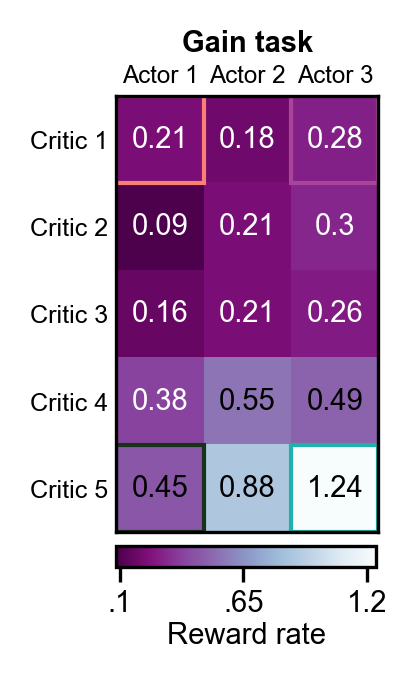

In [45]:
xticks = np.arange(len(Actors)); xticklabels = [f'Actor {i}' for i in range(1, 1 + len(Actors))]
yticks = np.arange(len(Critics)); yticklabels = [f'Critic {i}' for i in range(1, 1 + len(Critics))]
width = 1.5
height = 2.1

with initiate_plot(width, height, 300) as fig:
    ax = fig.add_subplot(111)
    ax.set_title('Gain task', fontsize=fontsize, fontweight='bold', pad=3)
    plt.xticks(xticks, xticklabels, fontsize=fontsize - 1.2)
    plt.yticks(yticks, yticklabels, fontsize=fontsize - 1)
    ax.set_xlabel('', fontsize=fontsize)
    ax.set_ylabel('', fontsize=fontsize)
        
    data = np.array([np.mean([df.rewarded.sum() / 
                              (np.sum([d.pos_x.size - 1 for d in df.itertuples()]) * arg.DT) for df in dfs]) 
                     for dfs in agent_trajectories_all]).reshape(len(Critics), len(Actors))
    cmatplot = ax.matshow(data, cmap='BuPu_r')  
    ax.tick_params(axis='both', which='major', pad=2, bottom=False, length=0)
    
    cbaxes = ax.inset_axes([0, -0.08, 0.99, 0.05]) 
    cbar = fig.colorbar(cmatplot, cax=cbaxes, orientation='horizontal')
    cbar.ax.tick_params(labelsize=fontsize, pad=2)
    cbar_ticks = [0.1, 0.65, 1.2]
    cbar.set_ticks(cbar_ticks)
    cbar.set_label('Reward rate', fontsize=fontsize)
    cbar.ax.xaxis.set_label_coords(0.5, -2.5)
    cbar.ax.xaxis.set_major_formatter(major_formatter)
    
    for iy, y in enumerate(np.arange(len(yticks))):
        for ix, x in enumerate(np.arange(len(xticks))):
            s = round(data[iy][ix], 2)
            c = 'k' if s > data.mean() else 'w'
            ax.text(x, y, s=s, fontsize=fontsize, 
                    c=c, va='center', ha='center')
            
    rect = Rectangle(xy=(-0.5, -0.5), width=1, height=1, fill=False, ec=holistic_c, lw=lw)
    ax.add_patch(rect)
    rect = Rectangle(xy=(1.5, -0.5), width=1, height=1, fill=False, ec=moact_hocri_c, lw=lw)
    ax.add_patch(rect)
    rect = Rectangle(xy=(-0.5, 3.5), width=1, height=1, fill=False, ec=hoact_mocri_c, lw=lw)
    ax.add_patch(rect)
    rect = Rectangle(xy=(1.5, 3.5), width=1, height=1, fill=False, ec=modular_c, lw=lw)
    ax.add_patch(rect)
    
    fig.tight_layout(pad=0, rect=(-0.01, 0, 0.99, 1))
    
    #plt.savefig(figure_path / 'raw/{name}.pdf'.format(
    #             name='reward_rate_gain'), orientation='portrait', format='pdf', transparent=True)

## 8e

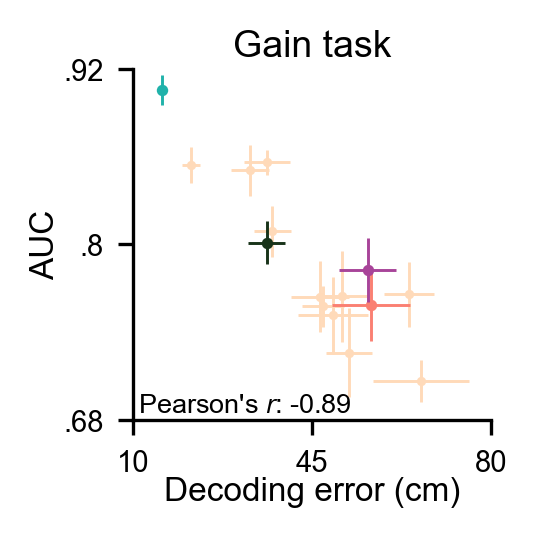

In [46]:
width = 1.65; height = 1.65
marker = 'o'; marker_size = 10; marker_lw = lw * 0.5

xticks = [10, 45, 80]
yticks = [0.68, 0.8, 0.92]

other_c = 'peachpuff'
colors = [holistic_c, other_c, moact_hocri_c] + [other_c] * 9 + [hoact_mocri_c, other_c, modular_c]
    
with initiate_plot(width, height, 300) as fig:
    ax = fig.add_subplot(1, 1, 1)
    ax.set_title('Gain task', fontsize=fontsize + 2, fontweight='normal', pad=3)
    ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
    plt.xticks(xticks, fontsize=fontsize)
    plt.yticks(yticks, fontsize=fontsize)
    ax.set_xlabel('Decoding error (cm)', fontsize=fontsize + 1)
    ax.set_ylabel(r'AUC', fontsize=fontsize + 1)
    ax.set_xlim(xticks[0], xticks[-1])
    ax.set_ylim(yticks[0], yticks[-1])
    ax.xaxis.set_label_coords(0.5, -0.16)
    ax.yaxis.set_label_coords(-0.2, 0.5)
    ax.xaxis.set_major_formatter(major_formatter)
    ax.yaxis.set_major_formatter(major_formatter)

    for agent_idx in range(auc_mean.size):
        c = colors[agent_idx]
        marker_size = 3 if c == other_c else 5
        zorder = -1 if c == other_c else 0
        ax.scatter(decoding_errors_mean.flatten()[agent_idx], auc_mean.flatten()[agent_idx], 
                   s=marker_size, lw=marker_lw, marker=marker, clip_on=False, c=c, zorder=zorder)
        ax.errorbar(decoding_errors_mean.flatten()[agent_idx], auc_mean.flatten()[agent_idx], 
                    yerr=auc_sem.flatten()[agent_idx], xerr=decoding_errors_sem.flatten()[agent_idx], 
                    c=c, lw=lw * 0.7, ls='none', zorder=zorder) 
        
    ax.text(11, 0.685, f"Pearson's $r$: {np.corrcoef(decoding_errors_mean.flatten(), auc_mean.flatten())[0][1]: 0.2f}",
            fontsize=fontsize - 0.5)
           
    fig.tight_layout(pad=0.15, rect=(0, 0, 1, 1))

    #plt.savefig(figure_path / 'raw/{name}.pdf'.format(
    #    name='corr_gain'), orientation='portrait', format='pdf', transparent=True)

# Perturbation

In [31]:
arg_pert = config.ConfigPerturb()
arg_pert.device = 'cpu'
arg_pert.perturbation_velocity_range = arg_pert.perturbation_velocity_range_large

## Select agent checkpoints for analyses

In [32]:
agent_paths_pert, agent_files_pert, perform_files_pert = select_agents_all(progress_agents_path, agent_archs, 
                                                                           MAX_TRAINING_T, task='perturbation_full')

## Run agents in the perturbation task

In [33]:
def RNN_agent_simulation_pert(arg, agent, target_positions, perturb_peaks, perturb_start_time_oris):
    reset_seeds(0)
    env = Env(arg)
    agent.bstep.obs_noise_range = arg.obs_noise_range

    pos_x = []; pos_y = []; pos_x_end = []; pos_y_end = []; head_dir = []; head_dir_end = []; pos_r = []
    pos_theta = []; pos_r_end = []; pos_theta_end = []; pos_v = []; pos_w = []
    target_x = []; target_y = []; target_r = []; target_theta = []
    rewarded = []; relative_radius = []; relative_angle = []
    action_v = []; action_w = []
    relative_radius_end = []; relative_angle_end = []; steps = []
    perturb_v = []; perturb_w = []; perturb_v_gauss = []; perturb_w_gauss = []
    state_ = []; action_ = []
    td_error = []

    for target_position, perturb_peak, perturb_start_time_ori in zip(target_positions, perturb_peaks,
                                                                     perturb_start_time_oris):
        cross_start_threshold = False
        reward = torch.zeros(1, 1, 1)
        x = env.reset(target_position=target_position, perturbation_velocities=perturb_peak,
                      perturbation_start_t=perturb_start_time_ori)
        agent.bstep.reset(env.pro_gains)
        last_action = torch.zeros([1, 1, arg.ACTION_DIM])
        last_action_raw = last_action.clone()

        state = torch.cat([x[-arg.OBS_DIM:].view(1, 1, -1), last_action,
                           env.target_position.view(1, 1, -1)], dim=2).to(arg.device)

        hidden_in = None

        true_states = []
        actions = []
        states = []
        rewards = []
        perturbations = []
        
        for t in range(arg.EPISODE_LEN):
            if not cross_start_threshold and (last_action_raw.abs() > arg.TERMINAL_ACTION).any():
                cross_start_threshold = True
            
            action, action_raw, hidden_out = agent.select_action(state, hidden_in, action_noise=None)
            next_x, reached_target, _ = env(x, action, t)
            next_ox = agent.bstep(next_x)
            next_state = torch.cat([next_ox.view(1, 1, -1), action,
                                    env.target_position_obs.view(1, 1, -1)], dim=2).to(arg.device)

            is_stop = env.is_stop(x, action)
            
            if is_stop and cross_start_threshold:
                reward = env.return_reward(x, reward_mode='mixed')

            true_states.append(x)
            states.append(state)
            actions.append(action)
            rewards.append(reward)
            perturbations.append(torch.stack((env.perturbation_vt, env.perturbation_wt)))

            if is_stop and cross_start_threshold:
                break
                
            last_action_raw = action_raw
            state = next_state
            x = next_x
            hidden_in = hidden_out

        # Trial end
        # TD errors
        states = torch.cat(states)
        actions = torch.cat(actions)
        rewards = torch.cat(rewards)
        dones = torch.zeros_like(rewards); dones[-1] = 1
        with torch.no_grad():
            Q = agent.critic.Q1(states, actions)
            next_Q = torch.zeros_like(Q); next_Q[:-1] = Q[1:]
            td_error_ = rewards + (1-dones) * arg.GAMMA * next_Q - Q
        
        td_error.append(abs(td_error_).mean().item())
        # others
        pos_x_temp, pos_y_temp, head_dir_temp, pos_v_temp, pos_w_temp \
                    = torch.chunk(torch.cat(true_states, dim=1), x.shape[0], dim=0)
        pos_x.append(pos_x_temp.view(-1).numpy() * arg.LINEAR_SCALE)
        pos_y.append(pos_y_temp.view(-1).numpy() * arg.LINEAR_SCALE)
        pos_x_end.append(pos_x[-1][-1])
        pos_y_end.append(pos_y[-1][-1])
        head_dir.append(np.rad2deg(head_dir_temp.view(-1).numpy()))
        pos_v.append(pos_v_temp.view(-1).numpy() * arg.LINEAR_SCALE)
        pos_w.append(np.rad2deg(pos_w_temp.view(-1).numpy()))
        head_dir_end.append(head_dir[-1][-1])

        rho, phi = cart2pol(pos_x[-1], pos_y[-1])
        pos_r.append(rho)
        pos_theta.append(np.rad2deg(phi))
        pos_r_end.append(rho[-1])
        pos_theta_end.append(np.rad2deg(phi[-1]))

        target_x.append(target_position[0].item() * arg.LINEAR_SCALE)
        target_y.append(target_position[1].item() * arg.LINEAR_SCALE)
        tar_rho, tar_phi = cart2pol(target_x[-1], target_y[-1])
        target_r.append(tar_rho)
        target_theta.append(np.rad2deg(tar_phi))
        
        state_.append(states)

        action_.append(actions)
        action_v_temp, action_w_temp = torch.chunk(actions.squeeze(1), 
                                                   action.shape[-1], dim=1)
        action_v.append(action_v_temp.view(-1).numpy())
        action_w.append(action_w_temp.view(-1).numpy())
        
        relative_r, relative_ang = get_relative_r_ang(pos_x[-1], pos_y[-1], head_dir[-1], 
                                                      target_x[-1], target_y[-1])
        relative_radius.append(relative_r)
        relative_angle.append(np.rad2deg(relative_ang))
        relative_radius_end.append(relative_r[-1])
        relative_angle_end.append(np.rad2deg(relative_ang[-1]))
        rewarded.append((reached_target & is_stop).item())
        
        steps.append(np.arange(relative_r.size))
        
        perturb_v.append(torch.stack(perturbations)[:, 0].numpy() * arg.LINEAR_SCALE)
        perturb_w.append(np.rad2deg(torch.stack(perturbations)[:, 1].numpy()))
        perturb_v_gauss.append(env.gaussian_v_array.numpy() * arg.LINEAR_SCALE)
        perturb_w_gauss.append(np.rad2deg(env.gaussian_w_array.numpy()))
        
    agent.bstep.obs_noise_range = config.ConfigGain().obs_noise_range

    return(pd.DataFrame().assign(pos_x=pos_x, pos_y=pos_y, pos_x_end=pos_x_end, pos_y_end=pos_y_end, 
                                 head_dir=head_dir, head_dir_end=head_dir_end, 
                                 pos_r=pos_r, pos_theta=pos_theta, 
                                 pos_r_end=pos_r_end, pos_theta_end=pos_theta_end, pos_v=pos_v, 
                                 pos_w=pos_w, target_x=target_x, target_y=target_y, 
                                 target_r=target_r,
                                 target_theta=target_theta, rewarded=rewarded,
                                 relative_radius=relative_radius, relative_angle=relative_angle,
                                 action_v=action_v, action_w=action_w, 
                                 relative_radius_end=relative_radius_end,
                                 relative_angle_end=relative_angle_end, steps=steps,
                                 perturb_v=perturb_v, perturb_w=perturb_w,
                                 perturb_vpeak=torch.stack(perturb_peaks)[:, 0].numpy() * arg.LINEAR_SCALE,
                                 perturb_wpeak=np.rad2deg(torch.stack(perturb_peaks)[:, 1].numpy()),
                                 perturb_start_time=torch.stack(perturb_start_time_oris).numpy(),
                                 perturb_v_gauss=perturb_v_gauss, perturb_w_gauss=perturb_w_gauss,
                                 gain_v=[env.process_gain_default[0].item() for _ in range(len(pos_x))],
                                 gain_w=[env.process_gain_default[1].item() for _ in range(len(pos_x))],
                                 state=state_, action=action_, td_error=td_error))

In [34]:
SAMPLE_SIZE = 2000
reset_seeds(0)

env = Env(arg_pert)
perturb_peaks = []; perturb_start_time = []
for _ in range(SAMPLE_SIZE):
    __ = env.reset()
    perturb_peaks.append(env.perturbation_velocities)
    perturb_start_time.append(env.perturbation_start_t)

In [35]:
agents_all_pert = []
for idx, agent_arch in enumerate(agent_archs):
    agents_ = []
    for agent_path, agent_file in zip(agent_paths_pert[idx], agent_files_pert[idx]):
        agent = Agent(arg_pert, eval(agent_arch[:6]), eval(agent_arch[6:]))
        agent.data_path = agent_path
        agent.load(agent_file, load_memory=False, load_optimzer=False)
        agents_.append(agent)
    agents_all_pert.append(agents_)

In [36]:
agent_trajectories_all_pert = [[RNN_agent_simulation_pert(arg_pert, agent, target_positions, perturb_peaks, 
                                                           perturb_start_time) 
                                for agent in agents_] 
                               for agents_ in agents_all_pert]

## S9c

In [37]:
max_reward_boundary = max([df.relative_radius_end.max() for dfs in agent_trajectories_all_pert for df in dfs]) + 1
hypo_reward_boundaries = np.arange(max_reward_boundary)

targets = agent_trajectories_all_pert[0][0][['target_x', 'target_y']].values
shuffled_targets = targets.copy()
rng = default_rng(1); rng.shuffle(shuffled_targets, axis=0)

ydata_subjects_pert = []; xdata_subjects_pert = []
for dfs in agent_trajectories_all_pert:
    ydata_seeds = []; xdata_seeds = []
    for df in dfs:
        ydata = []; xdata = []
        for reward_boundary in hypo_reward_boundaries:
            ydata.append((np.linalg.norm(df[['pos_x_end', 'pos_y_end']].values - targets, axis=1) 
                          < reward_boundary).sum() / len(df))
            xdata.append((np.linalg.norm(df[['pos_x_end', 'pos_y_end']].values - shuffled_targets, axis=1) 
                          < reward_boundary).sum() / len(df))
        ydata_seeds.append(ydata); xdata_seeds.append(xdata)
    ydata_subjects_pert.append(ydata_seeds); xdata_subjects_pert.append(xdata_seeds)
    
    
auc_data_pert = [[np.trapz(ydata_subjects_pert[agent_idx][idx], xdata_subjects_pert[agent_idx][idx]) 
                  for idx in range(len(agent_trajectories_all_pert[agent_idx]))] 
                 for agent_idx in range(len(agent_trajectories_all_pert))]
auc_mean_pert = np.array([np.mean(i) for i in auc_data_pert]).reshape(len(Critics), len(Actors))
auc_sem_pert = np.array([sem(i) for i in auc_data_pert]).reshape(len(Critics), len(Actors))

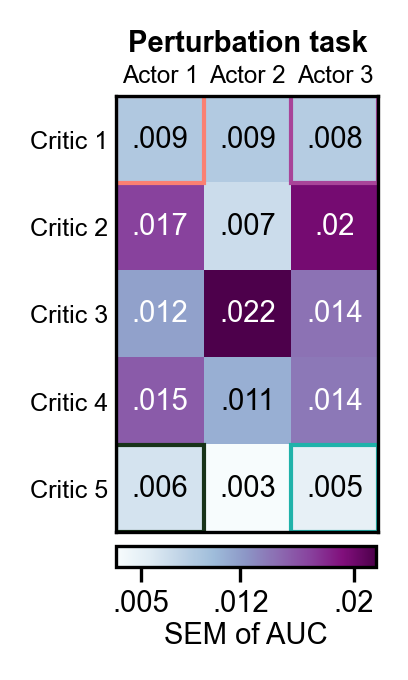

In [47]:
xticks = np.arange(len(Actors)); xticklabels = [f'Actor {i}' for i in range(1, 1 + len(Actors))]
yticks = np.arange(len(Critics)); yticklabels = [f'Critic {i}' for i in range(1, 1 + len(Critics))]
width = 1.5
height = 2.1

with initiate_plot(width, height, 300) as fig:
    ax = fig.add_subplot(111)
    ax.set_title('Perturbation task', fontsize=fontsize, fontweight='bold', pad=3)
    plt.xticks(xticks, xticklabels, fontsize=fontsize - 1.2)
    plt.yticks(yticks, yticklabels, fontsize=fontsize - 1)
    ax.set_xlabel('', fontsize=fontsize)
    ax.set_ylabel('', fontsize=fontsize)
        
    cmatplot = ax.matshow(auc_sem_pert, cmap='BuPu')    
    ax.tick_params(axis='both', which='major', pad=2, bottom=False, length=0)
    
    cbaxes = ax.inset_axes([0, -0.08, 0.99, 0.05]) 
    cbar = fig.colorbar(cmatplot, cax=cbaxes, orientation='horizontal')
    cbar.ax.tick_params(labelsize=fontsize, pad=2)
    cbar_ticks = [0.005, 0.012, 0.02]
    cbar.set_ticks(cbar_ticks)
    cbar.set_label('SEM of AUC', fontsize=fontsize)
    cbar.ax.xaxis.set_label_coords(0.5, -2.5)
    cbar.ax.xaxis.set_major_formatter(major_formatter)
    
    for iy, y in enumerate(np.arange(len(yticks))):
        for ix, x in enumerate(np.arange(len(xticks))):
            s = round(auc_sem_pert[iy][ix], 3)
            c = 'k' if s < auc_sem_pert.mean() else 'w'
            ax.text(x, y, s='.' + str(s).split('.')[1], fontsize=fontsize, 
                    c=c, va='center', ha='center')
    
    rect = Rectangle(xy=(-0.5, -0.5), width=1, height=1, fill=False, ec=holistic_c, lw=lw)
    ax.add_patch(rect)
    rect = Rectangle(xy=(1.5, -0.5), width=1, height=1, fill=False, ec=moact_hocri_c, lw=lw)
    ax.add_patch(rect)
    rect = Rectangle(xy=(-0.5, 3.5), width=1, height=1, fill=False, ec=hoact_mocri_c, lw=lw)
    ax.add_patch(rect)
    rect = Rectangle(xy=(1.5, 3.5), width=1, height=1, fill=False, ec=modular_c, lw=lw)
    ax.add_patch(rect)
    
    fig.tight_layout(pad=0, rect=(-0.01, 0, 0.99, 1))
    
    #plt.savefig(figure_path / 'raw/{name}.pdf'.format(
    #             name='auc_sem_pert'), orientation='portrait', format='pdf', transparent=True)

## 8d

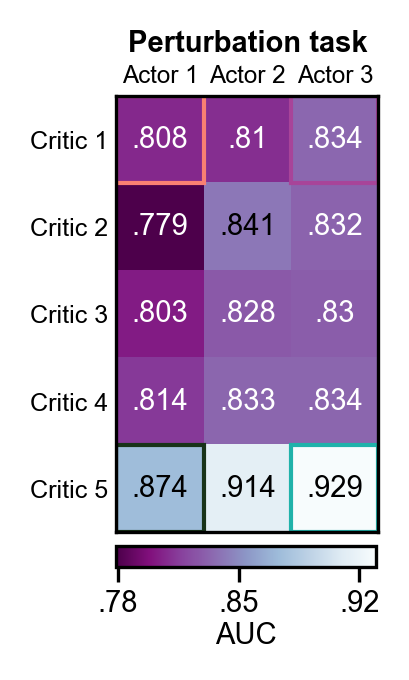

In [48]:
xticks = np.arange(len(Actors)); xticklabels = [f'Actor {i}' for i in range(1, 1 + len(Actors))]
yticks = np.arange(len(Critics)); yticklabels = [f'Critic {i}' for i in range(1, 1 + len(Critics))]
width = 1.5
height = 2.1

with initiate_plot(width, height, 300) as fig:
    ax = fig.add_subplot(111)
    ax.set_title('Perturbation task', fontsize=fontsize, fontweight='bold', pad=3)
    plt.xticks(xticks, xticklabels, fontsize=fontsize - 1.2)
    plt.yticks(yticks, yticklabels, fontsize=fontsize - 1)
    ax.set_xlabel('', fontsize=fontsize)
    ax.set_ylabel('', fontsize=fontsize)
        
    cmatplot = ax.matshow(auc_mean_pert, cmap='BuPu_r')    
    ax.tick_params(axis='both', which='major', pad=2, bottom=False, length=0)
    
    cbaxes = ax.inset_axes([0, -0.08, 0.99, 0.05]) 
    cbar = fig.colorbar(cmatplot, cax=cbaxes, orientation='horizontal')
    cbar.ax.tick_params(labelsize=fontsize, pad=2)
    cbar_ticks = [0.78, 0.85, 0.92]
    cbar.set_ticks(cbar_ticks)
    cbar.set_label('AUC', fontsize=fontsize)
    cbar.ax.xaxis.set_label_coords(0.5, -2.5)
    cbar.ax.xaxis.set_major_formatter(major_formatter)
    
    for iy, y in enumerate(np.arange(len(yticks))):
        for ix, x in enumerate(np.arange(len(xticks))):
            s = round(auc_mean_pert[iy][ix], 3)
            c = 'k' if s > auc_mean_pert.mean() else 'w'
            ax.text(x, y, s='.' + str(s).split('.')[1], fontsize=fontsize, 
                    c=c, va='center', ha='center')
    
    rect = Rectangle(xy=(-0.5, -0.5), width=1, height=1, fill=False, ec=holistic_c, lw=lw)
    ax.add_patch(rect)
    rect = Rectangle(xy=(1.5, -0.5), width=1, height=1, fill=False, ec=moact_hocri_c, lw=lw)
    ax.add_patch(rect)
    rect = Rectangle(xy=(-0.5, 3.5), width=1, height=1, fill=False, ec=hoact_mocri_c, lw=lw)
    ax.add_patch(rect)
    rect = Rectangle(xy=(1.5, 3.5), width=1, height=1, fill=False, ec=modular_c, lw=lw)
    ax.add_patch(rect)
    
    fig.tight_layout(pad=0, rect=(-0.01, 0, 0.99, 1))
    
    #plt.savefig(figure_path / 'raw/{name}.pdf'.format(
    #             name='auc_pert'), orientation='portrait', format='pdf', transparent=True)

In [38]:
_ = [[get_neural_response(agent, df) for agent, df in zip(agents_, dfs)] 
     for agents_, dfs in zip(agents_all_pert, agent_trajectories_all_pert)]

In [39]:
decoders_pert = [list(map(fit_decoder, dfs)) for dfs in agent_trajectories_all_pert]

In [40]:
decoding_errors_pert = [[np.linalg.norm(deco[0].predict(deco[1]) - deco[2], axis=1).mean() 
                         for deco in decoder] 
                        for decoder in decoders_pert]
decoding_errors_pert_mean = np.array([np.mean(v) for v in decoding_errors_pert]).reshape(len(Critics), len(Actors))
decoding_errors_pert_sem = np.array([sem(v) for v in decoding_errors_pert]).reshape(len(Critics), len(Actors))

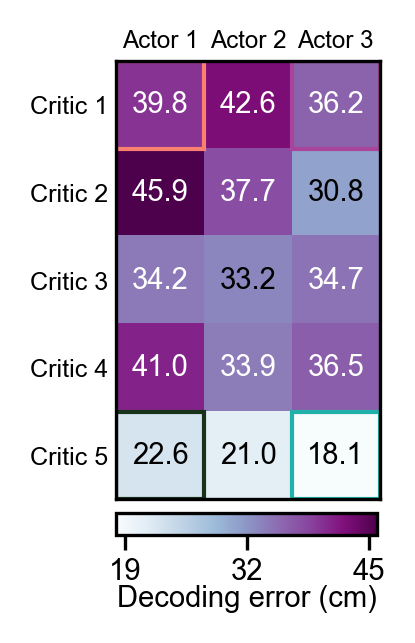

In [49]:
xticks = np.arange(len(Actors)); xticklabels = [f'Actor {i}' for i in range(1, 1 + len(Actors))]
yticks = np.arange(len(Critics)); yticklabels = [f'Critic {i}' for i in range(1, 1 + len(Critics))]
width = 1.5
height = 2.1

with initiate_plot(width, height, 300) as fig:
    ax = fig.add_subplot(111)
    plt.xticks(xticks, xticklabels, fontsize=fontsize - 1.2)
    plt.yticks(yticks, yticklabels, fontsize=fontsize - 1)
    ax.set_xlabel('', fontsize=fontsize)
    ax.set_ylabel('', fontsize=fontsize)
        
    cmatplot = ax.matshow(decoding_errors_pert_mean, cmap='BuPu')    
    ax.tick_params(axis='both', which='major', pad=2, bottom=False, length=0)
    
    cbaxes = ax.inset_axes([0, -0.08, 0.99, 0.05]) 
    cbar = fig.colorbar(cmatplot, cax=cbaxes, orientation='horizontal')
    cbar.ax.tick_params(labelsize=fontsize, pad=2)
    cbar_ticks = [19, 32, 45]
    cbar.set_ticks(cbar_ticks)
    cbar.set_label('Decoding error (cm)', fontsize=fontsize)
    cbar.ax.xaxis.set_label_coords(0.5, -2.3)
    cbar.ax.xaxis.set_major_formatter(major_formatter)
    
    for iy, y in enumerate(np.arange(len(yticks))):
        for ix, x in enumerate(np.arange(len(xticks))):
            s = round(decoding_errors_pert_mean[iy][ix], 1)
            c = 'k' if s < decoding_errors_pert_mean.mean() else 'w'
            ax.text(x, y, s=s, fontsize=fontsize, 
                    c=c, va='center', ha='center')
    
    rect = Rectangle(xy=(-0.5, -0.5), width=1, height=1, fill=False, ec=holistic_c, lw=lw)
    ax.add_patch(rect)
    rect = Rectangle(xy=(1.5, -0.5), width=1, height=1, fill=False, ec=moact_hocri_c, lw=lw)
    ax.add_patch(rect)
    rect = Rectangle(xy=(-0.5, 3.5), width=1, height=1, fill=False, ec=hoact_mocri_c, lw=lw)
    ax.add_patch(rect)
    rect = Rectangle(xy=(1.5, 3.5), width=1, height=1, fill=False, ec=modular_c, lw=lw)
    ax.add_patch(rect)
    
    fig.tight_layout(pad=0.45, rect=(-0.01, 0, 0.99, 1))
    
    #plt.savefig(figure_path / 'raw/{name}.pdf'.format(
    #             name='decoding_pert'), orientation='portrait', format='pdf', transparent=True)

## S9d

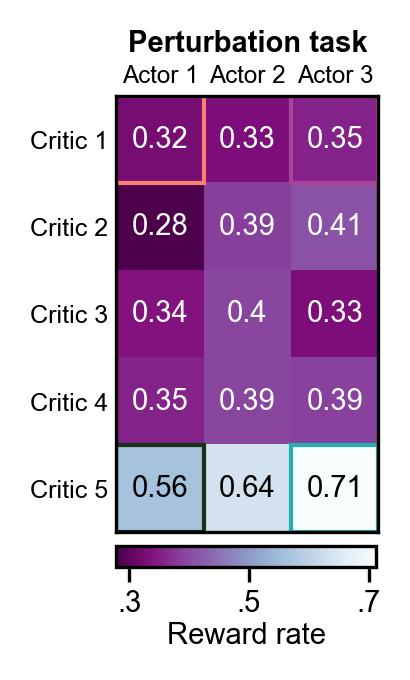

In [50]:
xticks = np.arange(len(Actors)); xticklabels = [f'Actor {i}' for i in range(1, 1 + len(Actors))]
yticks = np.arange(len(Critics)); yticklabels = [f'Critic {i}' for i in range(1, 1 + len(Critics))]
width = 1.5
height = 2.1

with initiate_plot(width, height, 300) as fig:
    ax = fig.add_subplot(111)
    ax.set_title('Perturbation task', fontsize=fontsize, fontweight='bold', pad=3)
    plt.xticks(xticks, xticklabels, fontsize=fontsize - 1.2)
    plt.yticks(yticks, yticklabels, fontsize=fontsize - 1)
    ax.set_xlabel('', fontsize=fontsize)
    ax.set_ylabel('', fontsize=fontsize)
        
    data = np.array([np.mean([df.rewarded.sum() / 
                              (np.sum([d.pos_x.size - 1 for d in df.itertuples()]) * arg.DT) for df in dfs]) 
                     for dfs in agent_trajectories_all_pert]).reshape(len(Critics), len(Actors))
    cmatplot = ax.matshow(data, cmap='BuPu_r')  
    ax.tick_params(axis='both', which='major', pad=2, bottom=False, length=0)
    
    cbaxes = ax.inset_axes([0, -0.08, 0.99, 0.05]) 
    cbar = fig.colorbar(cmatplot, cax=cbaxes, orientation='horizontal')
    cbar.ax.tick_params(labelsize=fontsize, pad=2)
    cbar_ticks = [0.3, 0.5, 0.7]
    cbar.set_ticks(cbar_ticks)
    cbar.set_label('Reward rate', fontsize=fontsize)
    cbar.ax.xaxis.set_label_coords(0.5, -2.5)
    cbar.ax.xaxis.set_major_formatter(major_formatter)
    
    for iy, y in enumerate(np.arange(len(yticks))):
        for ix, x in enumerate(np.arange(len(xticks))):
            s = round(data[iy][ix], 2)
            c = 'k' if s > data.mean() else 'w'
            ax.text(x, y, s=s, fontsize=fontsize, 
                    c=c, va='center', ha='center')
            
    rect = Rectangle(xy=(-0.5, -0.5), width=1, height=1, fill=False, ec=holistic_c, lw=lw)
    ax.add_patch(rect)
    rect = Rectangle(xy=(1.5, -0.5), width=1, height=1, fill=False, ec=moact_hocri_c, lw=lw)
    ax.add_patch(rect)
    rect = Rectangle(xy=(-0.5, 3.5), width=1, height=1, fill=False, ec=hoact_mocri_c, lw=lw)
    ax.add_patch(rect)
    rect = Rectangle(xy=(1.5, 3.5), width=1, height=1, fill=False, ec=modular_c, lw=lw)
    ax.add_patch(rect)
    
    fig.tight_layout(pad=0, rect=(-0.01, 0, 0.99, 1))
    
    #plt.savefig(figure_path / 'raw/{name}.pdf'.format(
    #             name='reward_rate_pert'), orientation='portrait', format='pdf', transparent=True)

## 8f

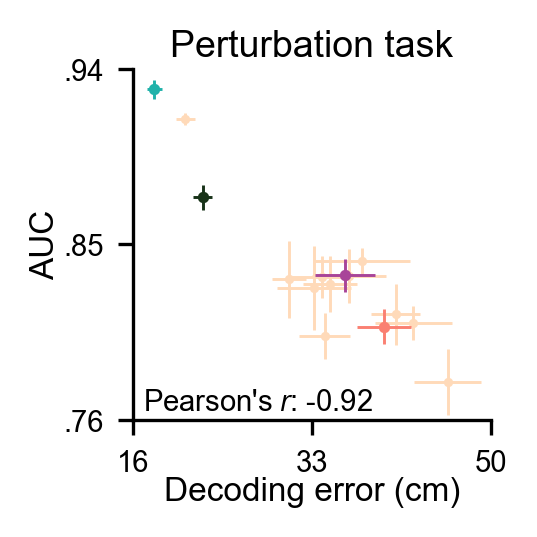

In [51]:
width = 1.65; height = 1.65
marker = 'o'; marker_size = 10; marker_lw = lw * 0.5

xticks = [16, 33, 50]
yticks = [0.76, 0.85, 0.94]

other_c = 'peachpuff'
colors = [holistic_c, other_c, moact_hocri_c] + [other_c] * 9 + [hoact_mocri_c, other_c, modular_c]
    
with initiate_plot(width, height, 300) as fig:
    ax = fig.add_subplot(1, 1, 1)
    ax.set_title('Perturbation task', fontsize=fontsize + 2, fontweight='normal', pad=3)
    ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
    plt.xticks(xticks, fontsize=fontsize)
    plt.yticks(yticks, fontsize=fontsize)
    ax.set_xlabel('Decoding error (cm)', fontsize=fontsize + 1)
    ax.set_ylabel(r'AUC', fontsize=fontsize + 1)
    ax.set_xlim(xticks[0], xticks[-1])
    ax.set_ylim(yticks[0], yticks[-1])
    ax.xaxis.set_label_coords(0.5, -0.16)
    ax.yaxis.set_label_coords(-0.2, 0.5)
    ax.xaxis.set_major_formatter(major_formatter)
    ax.yaxis.set_major_formatter(major_formatter)

    for agent_idx in range(auc_mean_pert.size):
        c = colors[agent_idx]
        marker_size = 3 if c == other_c else 5
        zorder = -1 if c == other_c else 0
        ax.scatter(decoding_errors_pert_mean.flatten()[agent_idx], auc_mean_pert.flatten()[agent_idx], 
                   s=marker_size, lw=marker_lw, marker=marker, clip_on=False, c=c, zorder=zorder)
        ax.errorbar(decoding_errors_pert_mean.flatten()[agent_idx], auc_mean_pert.flatten()[agent_idx], 
                    yerr=auc_sem_pert.flatten()[agent_idx], xerr=decoding_errors_pert_sem.flatten()[agent_idx], 
                    c=c, lw=lw * 0.7, ls='none', zorder=zorder) 
        
    ax.text(17, 0.765, 
            f"Pearson's $r$: {np.corrcoef(decoding_errors_pert_mean.flatten(), auc_mean_pert.flatten())[0][1]: 0.2f}",
            fontsize=fontsize)
           
    fig.tight_layout(pad=0.15, rect=(0, 0, 1, 1))

    #plt.savefig(figure_path / 'raw/{name}.pdf'.format(
    #    name='corr_pert'), orientation='portrait', format='pdf', transparent=True)